In [1]:
from unityagents import UnityEnvironment
import numpy as np

from models import Actor, MACritic
from DDPG import MADDPG
from tools import PlotTool, ReplayBuffer

from unityagents import UnityEnvironment
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, torch.cuda.is_available())

from ipywidgets import *
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib notebook

cuda:0 True


In [2]:
env         = UnityEnvironment(file_name="../Tennis_Linux/Tennis.x86_64", no_graphics=False)
brain_name  = env.brain_names[0]
brain       = env.brains[brain_name]
env_info    = env.reset(train_mode=True)[brain_name]
num_agents  = len(env_info.agents)
action_size = brain.vector_action_space_size
state_size  = len(env_info.vector_observations[0])
print("state size:",state_size, "action size:", action_size)
print("state shape: ", env_info.vector_observations.shape)

DEBUG:unityagents:The true file name is Tennis
DEBUG:unityagents:This is the launch string /home/yousof/AI/courses/deep_RL_udacity/projects/DRLND_Collaboration_Competition_P3/../Tennis_Linux/Tennis.x86_64
INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


state size: 24 action size: 2
state shape:  (2, 24)


In [3]:
agents = []
batch_size = 1024
shared_buffer = ReplayBuffer(batch_size=batch_size, buffer_size=300 * 1000, seed=1, device=device)

for _ in range(num_agents):
    agent = MADDPG(state_size=state_size, 
                   action_size=action_size, 
                   actor_model=Actor,
                   critic_model=MACritic,
                   device=device,
                   num_agents= 1, # number of non-interacting agents,
                   num_interacting_agents = 2,
                   seed=1,
                   tau=1e-1,
                   batch_size=batch_size,
                   discount_factor = 0.99,
                   actor_learning_rate=1e-4,
                   critic_learning_rate=1e-3,
                   replayBuffer= shared_buffer) #shared_buffer
    agents.append(agent)
    
agents[0].load_agent('MADDPG_agent0_0.pth',is_exact_path=True)
agents[1].load_agent('MADDPG_agent1_0.pth',is_exact_path=True)    
agents[0].set_other_agent(agents[1])
agents[1].set_other_agent(agents[0])


In [8]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
states = env_info.vector_observations              # get the current state
score = 0
step = 0

<IPython.core.display.Javascript object>


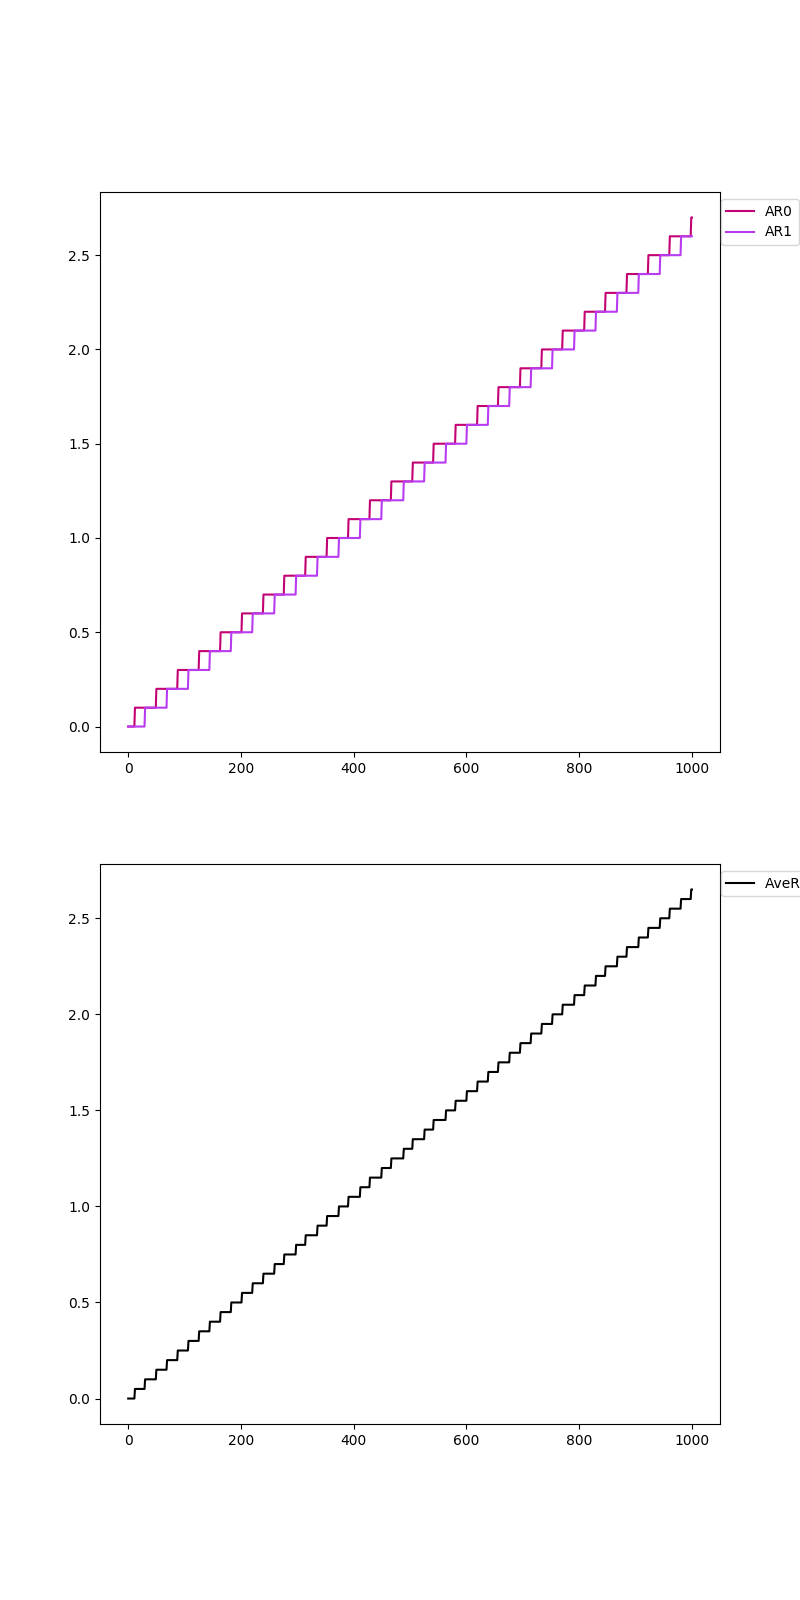

In [9]:
%matplotlib notebook
rewardPlot = PlotTool(number_of_lines=num_agents, desc = "R" )

#env_info = env.reset(train_mode=False)[brain_name] # reset the environment
states = env_info.vector_observations              # get the current state
score = 0
step = 0


while True:
    actions = None
    for i, agent in enumerate(agents):
        _, actions_without_noise  = agent.act(states[i],add_noise=True)
        agent_actions = np.clip(actions_without_noise, -1, 1)
        if actions is not None:
            actions = np.concatenate((actions,agent_actions),axis=0)
        else:
            actions = agent_actions

    env_info = env.step(actions)[brain_name]
    states = env_info.vector_observations
    reward = env_info.rewards
    score = score + np.array(reward)
    rewardPlot.push_date(score.reshape(1, num_agents))
    step += 1
    if step % 20 == 0:
        rewardPlot.draw()
    #if step == 21:
    #    input("Press Enter to continue...")
    if np.any(env_info.local_done):
        break
rewardPlot.draw()

In [10]:
env.close()